In [2]:
DATA_DIR = "../data/laks"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("..")

import importlib
import src.laks_data

In [5]:
from src.laks_data import Laks

laks = Laks(DATA_DIR=DATA_DIR)

In [6]:
F = laks.get_cell_fractions()
F

mutation,10:100129846:C:A,10:100185101:A:G,10:100209326:T:C,10:100283942:C:T,10:10086005:G:T,10:100873589:A:T,10:101108222:C:A,10:101108223:T:C,10:101427318:G:C,10:101884473:T:A,...,X:97291714:A:T,X:97396419:C:A,X:97564955:T:C,X:97583306:G:T,X:98177771:A:C,X:98278474:C:A,X:98452192:T:C,X:98700894:C:T,X:99136386:C:T,X:99571629:G:T
clone_id,,,,,,,,,,,,,,,,,,,,,
A,0.0,0.0,1.0,0.000000,0.833333,0.000000,0.000000,0.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.434783,1.000000,0.000000,0.0,1.000000,0.0,0.000000
B,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.000000,0.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.800000,1.000000,0.000000,0.0,1.000000,0.0,0.000000
C,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.066667,0.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.000000,0.0,0.000000
D,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.000000,0.555556,0.000000,1.0,1.000000,0.0,0.000000
E,1.0,1.0,1.0,0.784314,0.000000,1.000000,0.625000,0.625,0.606061,1.0,...,0.0,0.769231,0.095238,0.000000,0.666667,0.000000,0.0,0.952381,1.0,0.000000
F,1.0,1.0,1.0,1.000000,0.000000,0.190476,1.000000,1.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,1.0,0.000000
G,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1.0,...,1.0,0.000000,1.000000,0.000000,1.000000,0.842105,0.0,1.000000,0.0,0.909091
H,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.173913,0.000,0.000000,1.0,...,1.0,0.000000,1.000000,0.000000,1.000000,0.909091,0.0,1.000000,0.0,1.000000
I,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1.0,...,1.0,0.000000,1.000000,0.000000,0.869565,0.250000,0.0,1.000000,0.0,1.000000


In [7]:
from src.phylogeny_utils import plot_spectral_clustering

In [8]:
plot_spectral_clustering(F, filepath="../data/laks/scope/spectral_clustering.png")

# K-means Clustering

In [9]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score


ranges = range(9, 15, 1)
runs_per_k = 10

X = F.T.to_numpy()

silhouette_scores = []
all_labels = []


for k in ranges:
    print("Running K-Means with k=", k)
    for i in range(runs_per_k):
        kmeans = KMeans(n_clusters=k, random_state=i * 100)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
        all_labels.append(labels)

Running K-Means with k= 9
Running K-Means with k= 10
Running K-Means with k= 11
Running K-Means with k= 12
Running K-Means with k= 13
Running K-Means with k= 14


In [10]:
sillhouettes_scores_per_k = np.array(silhouette_scores).reshape((len(ranges), runs_per_k))
best_silhouettes_for_k = np.min(sillhouettes_scores_per_k, axis=1)
best_silhouettes_for_k

array([0.6058519 , 0.58074426, 0.55583069, 0.53371578, 0.53737277,
       0.53590316])

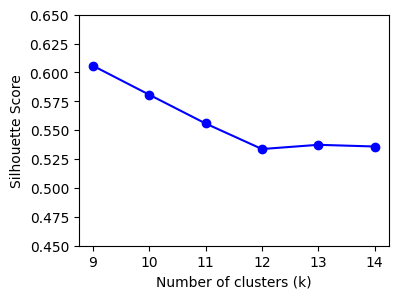

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))

plt.plot(ranges, best_silhouettes_for_k, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.ylim(0.45, 0.65)
plt.savefig("../data/laks/scope/silouette_scores.svg")

In [12]:
best_k = 12

ranges = np.array(ranges)
index_of_best_k = int(np.where(ranges == best_k)[0][0])
silhouette_scores_of_best_k = sillhouettes_scores_per_k[index_of_best_k, :]
best_label_index_of_best_best = np.argmin(silhouette_scores_of_best_k)
labels_per_k = np.array(all_labels).reshape((len(ranges), runs_per_k, -1))
best_labels = labels_per_k[index_of_best_k, best_label_index_of_best_best]

In [13]:
import pandas as pd

kmeans_labels = pd.DataFrame({
    'mutation': F.columns.to_list(),
    'clone': best_labels
})
kmeans_labels

,mutation,clone
0,10:100129846:C:A,1
1,10:100185101:A:G,1
2,10:100209326:T:C,2
3,10:100283942:C:T,9
4,10:10086005:G:T,7
...,...,...
14063,X:98278474:C:A,0
14064,X:98452192:T:C,5
14065,X:98700894:C:T,2
14066,X:99136386:C:T,1


In [14]:
# kmeans_labels.loc[kmeans_labels['clone'] == 8, 'clone'] = 2
# kmeans_labels.loc[kmeans_labels['clone'] == 11, 'clone'] = 2

In [15]:
kmeans_labels.groupby("clone")["mutation"].count()

clone
0      310
1     2406
2     1788
3     1186
4     1400
5      640
6     3133
7      685
8     1126
9      953
10     248
11     193
Name: mutation, dtype: int64

['I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A']


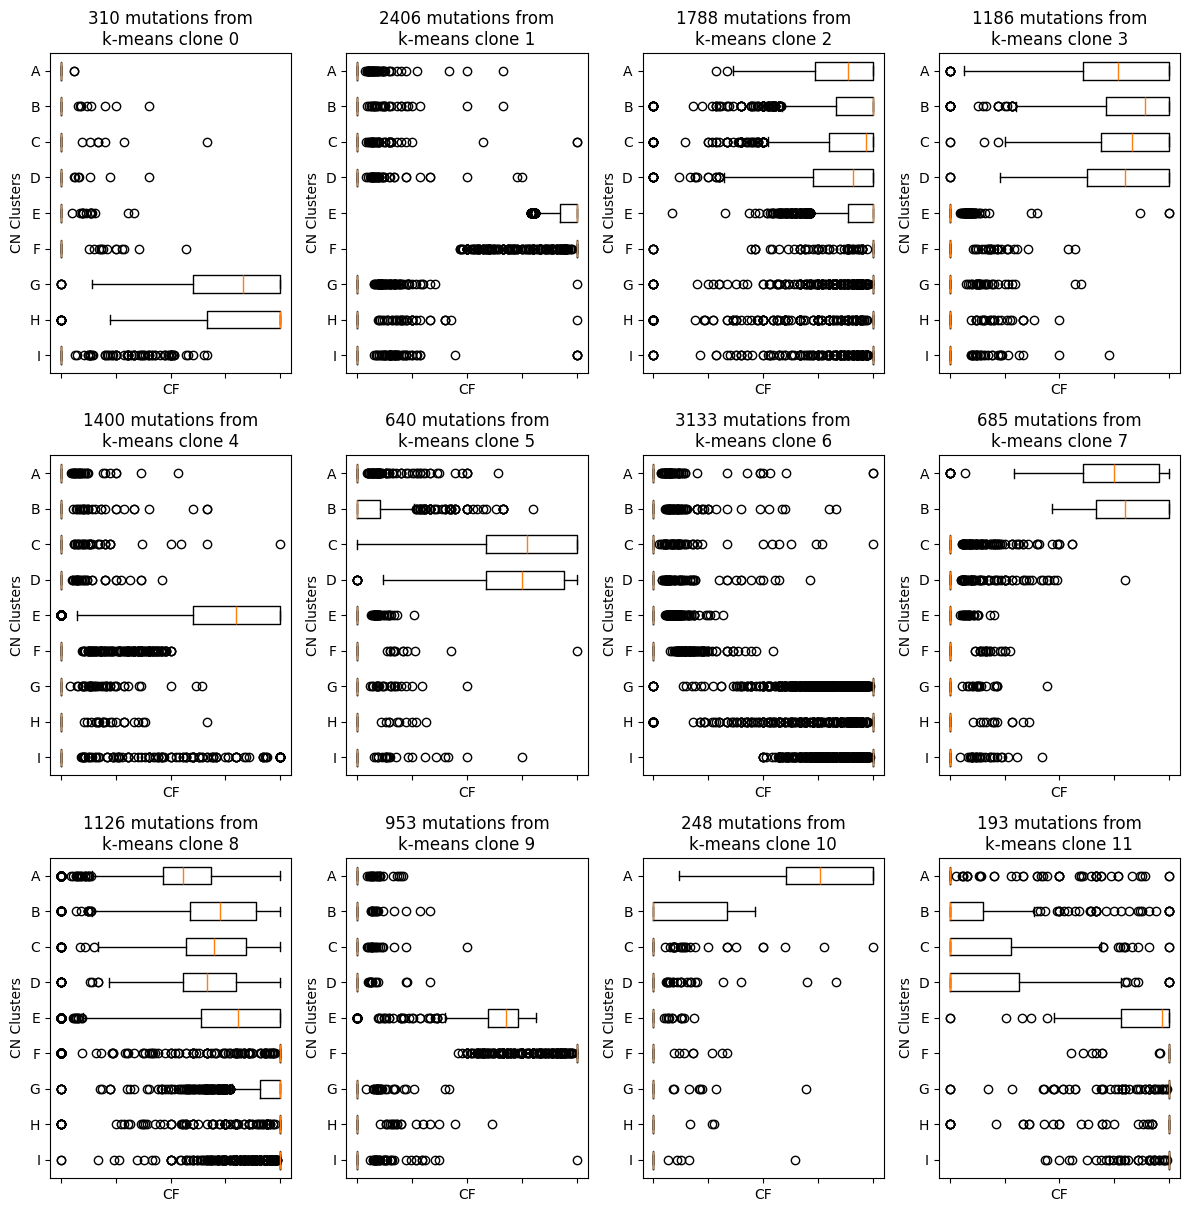

In [16]:
import matplotlib.pyplot as plt
import numpy as np

clusters = sorted(kmeans_labels["clone"].unique())
n_clusters = len(clusters)

# Set up subplot grid: 2 columns
n_cols = 4
n_rows = (n_clusters + 5) // n_cols

fig, axes = plt.subplots(
    nrows=n_rows, ncols=n_cols,
    figsize=(12, 4 * n_rows),
    sharex=True
)

axes = axes.flatten()

# Define explicit CN cluster order
cn_order = sorted(F.index.unique())[::-1]  # or use a fixed list if known: ['A','B','C','D','E','F','G','H','I']
print(cn_order)

for i, cluster in enumerate(clusters):
    ax = axes[i]

    # Get mutations for this cluster
    mutations_in_cluster = kmeans_labels[kmeans_labels["clone"] == cluster]["mutation"]

    df = F[mutations_in_cluster]

    # Ensure consistent y-axis order (A→I)
    df = df.loc[cn_order]

    F_clust = df.to_numpy()

    thres = 0.75
    median = np.median(F_clust, axis=1)
    upper_percentiles = np.percentile(F_clust, axis=1, q=int(100 * thres))
    lower_percentiles = np.percentile(F_clust, axis=1, q=int(100 * (1 - thres)))

    # Horizontal boxplot per clone, sorted A→I
    ax.boxplot(df.T.values, vert=False, tick_labels=df.index)

    ax.set_ylabel("CN Clusters")
    ax.set_xlabel("CF")
    ax.set_title(f"{df.shape[1]} mutations from\nk-means clone {cluster}")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [17]:
def get_F_boundaries(F, mutation_group_mapping, thres=0.75):

    mutation_groups = sorted(mutation_group_mapping["clone"].unique())
    
    medians = np.zeros((F.shape[0], len(mutation_groups)))
    upper_percentiles = np.zeros((F.shape[0], len(mutation_groups)))
    lower_percentiles = np.zeros((F.shape[0], len(mutation_groups)))

    for i in range(len(mutation_groups)):
        mut_grp = mutation_groups[i]
        mutations_in_group = mutation_group_mapping[mutation_group_mapping["clone"] == mut_grp]["mutation"]

        df = F[mutations_in_group]
        F_clone = df.to_numpy()

        med = np.median(F_clone, axis=1)
        upp = np.percentile(F_clone, axis=1, q=int(100*thres))
        low = np.percentile(F_clone, axis=1, q=int(100*(1-thres)))

        medians[:, i] = med
        upper_percentiles[:, i] = upp
        lower_percentiles[:, i] = low
    
    F_bar = pd.DataFrame(medians, index=F.index, columns=mutation_groups)
    F_hi  = pd.DataFrame(upper_percentiles, index=F.index, columns=mutation_groups)
    F_lo  = pd.DataFrame(lower_percentiles, index=F.index, columns=mutation_groups)

    return F_bar, F_hi, F_lo


In [18]:
F_bar, F_hi, F_lo = get_F_boundaries(F, kmeans_labels, 0.75)

In [19]:
F_bar

,0,1,2,3,4,5,6,7,8,9,10,11
clone_id,,,,,,,,,,,,
A,0.000000,0.0,0.888889,0.769231,0.0,0.00000,0.0,0.75,0.555556,0.000000,0.759615,0.000000
B,0.000000,0.0,1.000000,0.888889,0.0,0.00000,0.0,0.80,0.727273,0.000000,0.000000,0.000000
C,0.000000,0.0,0.967742,0.833333,0.0,0.77592,0.0,0.00,0.696663,0.000000,0.000000,0.000000
D,0.000000,0.0,0.909091,0.800000,0.0,0.75000,0.0,0.00,0.666667,0.000000,0.000000,0.000000
E,0.000000,1.0,1.000000,0.000000,0.8,0.00000,0.0,0.00,0.806452,0.677966,0.000000,0.967742
F,0.000000,1.0,1.000000,0.000000,0.0,0.00000,0.0,0.00,1.000000,1.000000,0.000000,1.000000
G,0.828431,0.0,1.000000,0.000000,0.0,0.00000,1.0,0.00,1.000000,0.000000,0.000000,1.000000
H,1.000000,0.0,1.000000,0.000000,0.0,0.00000,1.0,0.00,1.000000,0.000000,0.000000,1.000000
I,0.000000,0.0,1.000000,0.000000,0.0,0.00000,1.0,0.00,1.000000,0.000000,0.000000,1.000000


In [20]:
F_hi

,0,1,2,3,4,5,6,7,8,9,10,11
clone_id,,,,,,,,,,,,
A,0.0,0.0,1.0,1.0,0.0,0.000000,0.0,0.952381,0.681818,0.000000,1.000000,0.000000
B,0.0,0.0,1.0,1.0,0.0,0.105263,0.0,1.000000,0.887255,0.000000,0.333333,0.153846
C,0.0,0.0,1.0,1.0,0.0,1.000000,0.0,0.000000,0.842105,0.000000,0.000000,0.277778
D,0.0,0.0,1.0,1.0,0.0,0.942724,0.0,0.000000,0.800000,0.000000,0.000000,0.315789
E,0.0,1.0,1.0,0.0,1.0,0.000000,0.0,0.000000,0.997748,0.735294,0.000000,1.000000
F,0.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,1.000000
G,1.0,0.0,1.0,0.0,0.0,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000
H,1.0,0.0,1.0,0.0,0.0,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000
I,0.0,0.0,1.0,0.0,0.0,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000


In [21]:
F_lo

,0,1,2,3,4,5,6,7,8,9,10,11
clone_id,,,,,,,,,,,,
A,0.000000,0.000000,0.736842,0.606061,0.000000,0.000000,0.0,0.606061,0.465116,0.000000,0.606061,0.000000
B,0.000000,0.000000,0.833333,0.714286,0.000000,0.000000,0.0,0.666667,0.588235,0.000000,0.000000,0.000000
C,0.000000,0.000000,0.800000,0.689655,0.000000,0.588235,0.0,0.000000,0.571429,0.000000,0.000000,0.000000
D,0.000000,0.000000,0.727273,0.625000,0.000000,0.588235,0.0,0.000000,0.555556,0.000000,0.000000,0.000000
E,0.000000,0.925926,0.888889,0.000000,0.601807,0.000000,0.0,0.000000,0.638298,0.595238,0.000000,0.782609
F,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,1.000000
G,0.601515,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.909091,0.000000,0.000000,1.000000
H,0.666667,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000
I,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000


In [22]:
cluster_weights = kmeans_labels.groupby("clone").size().tolist()
cluster_weights

[310, 2406, 1788, 1186, 1400, 640, 3133, 685, 1126, 953, 248, 193]

In [23]:
sum(cluster_weights)

14068

In [24]:
import importlib
import src.solve_ilp_2
import src.phylogeny_utils

importlib.reload(src.solve_ilp_2)
importlib.reload(src.phylogeny_utils)

<module 'src.phylogeny_utils' from '/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py'>

In [ ]:
from src.solve_ilp_2 import solve_cncff

total_clones = F_hi.shape[1] + 1
n_clones = total_clones

while n_clones >= 1:

    solutions, value, status = solve_cncff(F_hi, F_lo, n_clones=n_clones, n_solutions=1, cluster_weights=cluster_weights, time_limit=60 * 10)

    if len(solutions) > 0:
        solutions, value, status = solve_cncff(F_hi, F_lo, n_clones=n_clones, n_solutions=100, cluster_weights=cluster_weights, time_limit=60 * 10)
        break

    n_clones -= 1


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2687964
Academic license 2687964 - for non-commercial use only - registered to sa___@iict.buet.ac.bd
Set parameter TimeLimit to value 600
Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 1
Set parameter PoolGap to value 0
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  600
PoolSolutions  1
PoolSearchMode  2
PoolGap  0

Academic license 2687964 - for non-commercial use only - registered to sa___@iict.buet.ac.bd
Optimize a model with 15407 rows, 4329 columns and 44214 nonzeros
Model fingerprint: 0x5f5fb52e
Model has 216 quadratic constraints
Variable types: 1629 continuous, 2700 integer (2700 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   

In [49]:
len(solutions)

18

In [50]:
from src.phylogeny_utils import generate_perfect_phylogeny, draw_clone_tree, add_clusters_to_clonal_T, fix_T

In [51]:
import networkx as nx

def canonical_form(G):
    if not nx.is_tree(G):
        raise ValueError("Graph must be a tree")
    if "root" not in G:
        raise ValueError("Tree must contain a node named 'root'")
    return _encode_tree(G, "root", None)

def _encode_tree(G, node, parent):
    children = [n for n in G.neighbors(node) if n != parent]
    encoded_children = sorted(_encode_tree(G, c, node) for c in children)
    # include the current node label in the encoding
    return f"{node}({''.join(encoded_children)})"


In [52]:
a = 0
b = 1

Xa, Ba, Ua, Fa, Ga = solutions[a]
Xb, Bb, Ub, Fb, Gb = solutions[b]

print(np.array_equal(Xa.to_numpy(), Xb.to_numpy()))
print(np.array_equal(Ba.to_numpy(), Bb.to_numpy()))
print(np.array_equal(Fa.to_numpy(), Fb.to_numpy()))
print(np.array_equal(Ua.to_numpy(), Ub.to_numpy()))
print(np.array_equal(Ga.to_numpy(), Gb.to_numpy()))

True
False
False
False
False


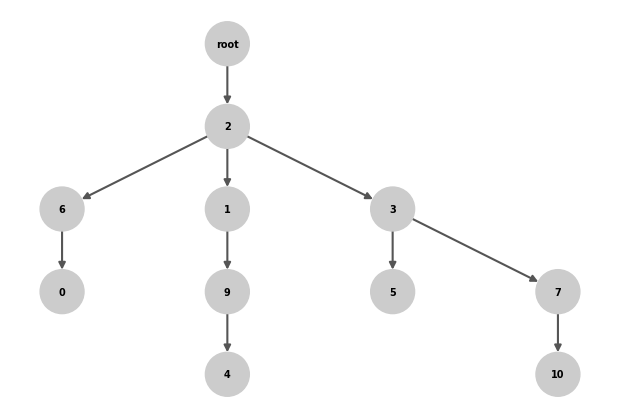

/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


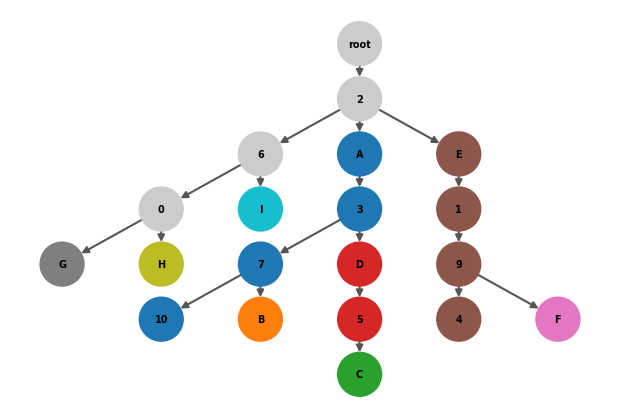

In [53]:
X, B, U, F, G = solutions[2]
solT_mut, solT_cell = generate_perfect_phylogeny(B)
draw_clone_tree(solT_mut)

# fixed_T = fix_T(B, G, solT_cell)

fixed_T = add_clusters_to_clonal_T(solT_mut, X, G, B)
draw_clone_tree(fixed_T)

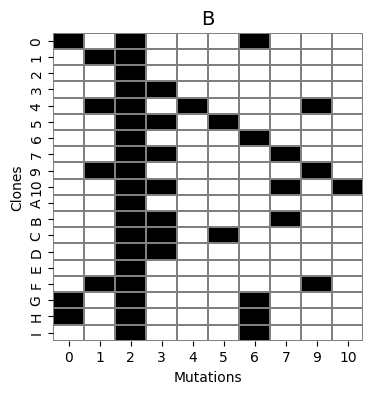

In [54]:
df_binary = B
df_binary = df_binary[df_binary.sum().sort_values(ascending=False).index]    

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(B,
            cmap=sns.color_palette(["white", "black"]),  # 0=white, 1=green
            cbar=False,
            linewidths=0.2,
            linecolor="grey")

plt.title("B", fontsize=14)
plt.xlabel("Mutations")
plt.ylabel("Clones")
plt.show()

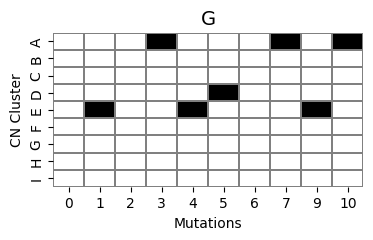

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,2))
sns.heatmap(G,
            cmap=sns.color_palette(["white", "black"]),  # 0=white, 1=green
            cbar=False,
            linewidths=0.2,
            linecolor="grey")

plt.title("G", fontsize=14)
plt.xlabel("Mutations")
plt.ylabel("CN Cluster")
plt.show()


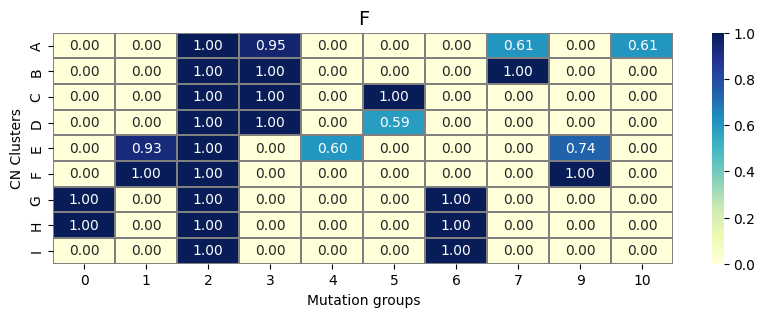

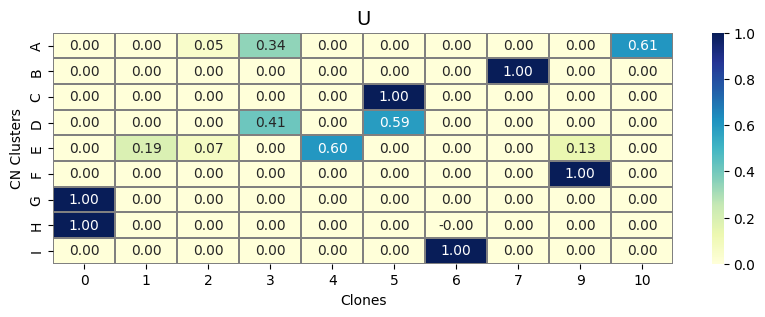

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))

sns.heatmap(F.astype(float),
            annot=True,       # print values inside
            fmt=".2f",        # format to 2 decimals
            cmap="YlGnBu",    # color map (yellow→green→blue)
            cbar=True,
            linewidths=0.2,
            linecolor="grey")

plt.title("F", fontsize=14)
plt.xlabel("Mutation groups")
plt.ylabel("CN Clusters")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))

sns.heatmap(U.astype(float),
            annot=True,       # print values inside
            fmt=".2f",        # format to 2 decimals
            cmap="YlGnBu",    # color map (yellow→green→blue)
            cbar=True,
            linewidths=0.2,
            linecolor="grey")

plt.title("U", fontsize=14)
plt.xlabel("Clones")
plt.ylabel("CN Clusters")
plt.show()


0


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


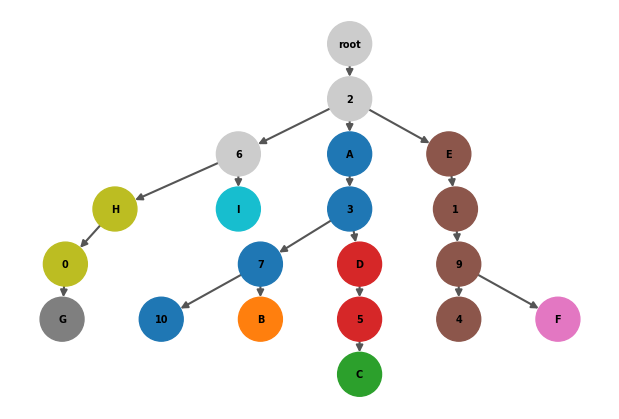

1


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


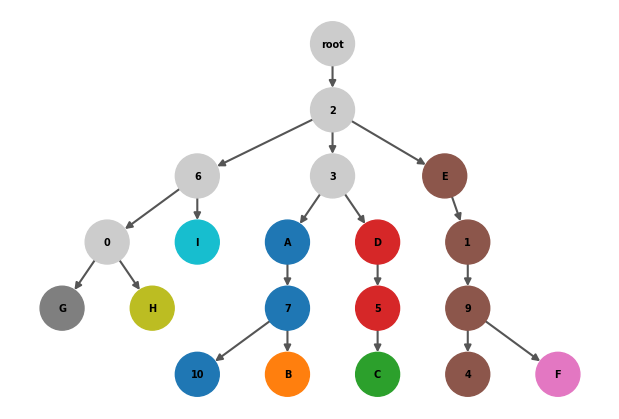

2


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


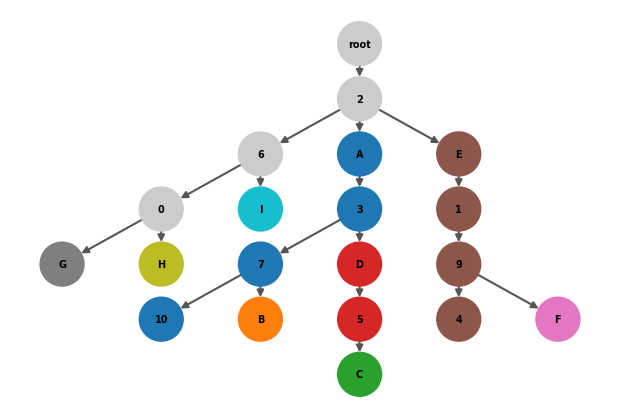

3


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


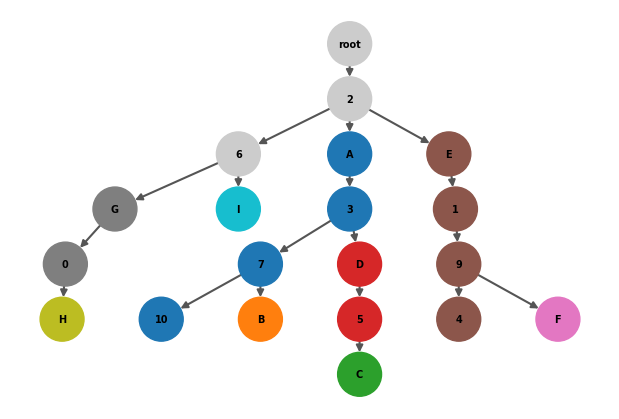

4


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


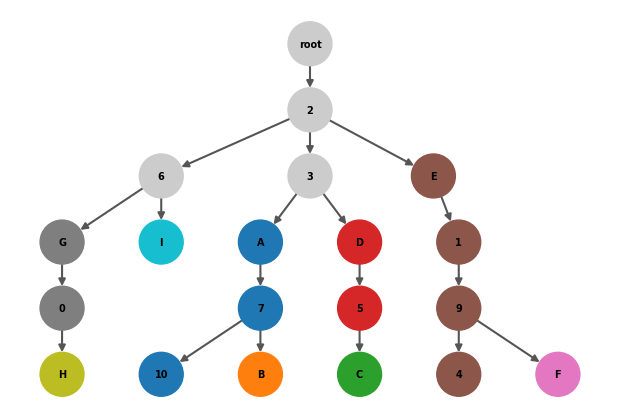

5


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


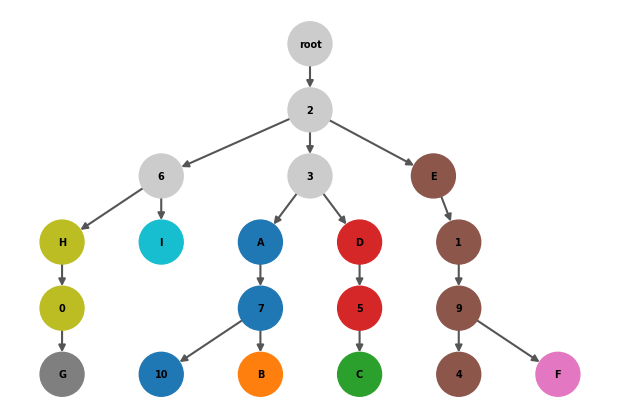

6


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


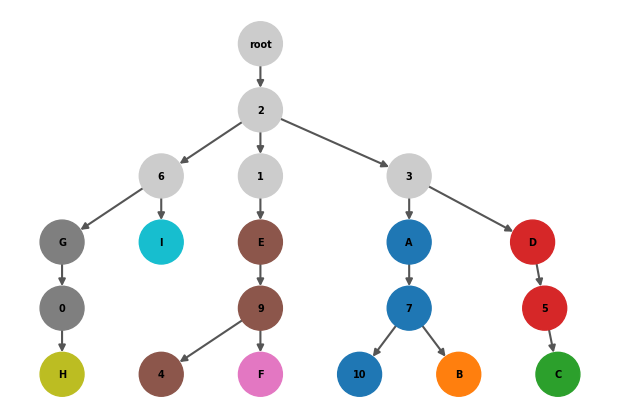

7


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


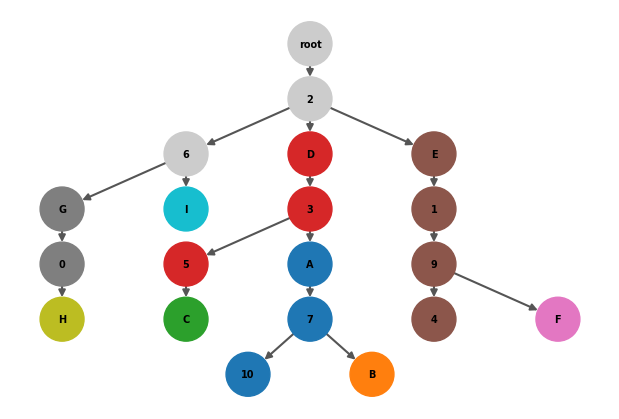

8


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


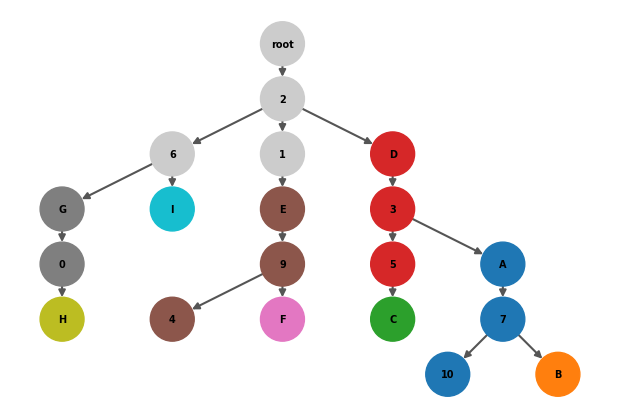

9


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


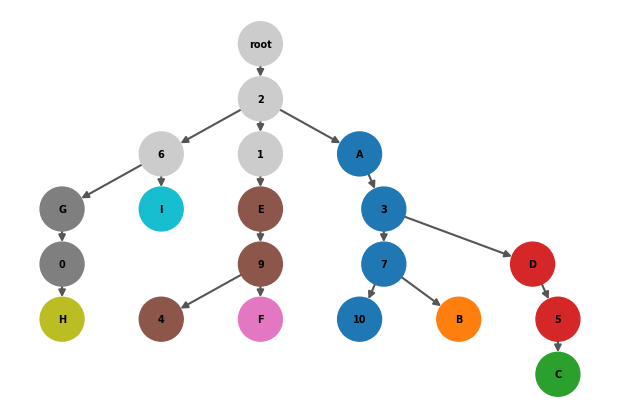

10


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


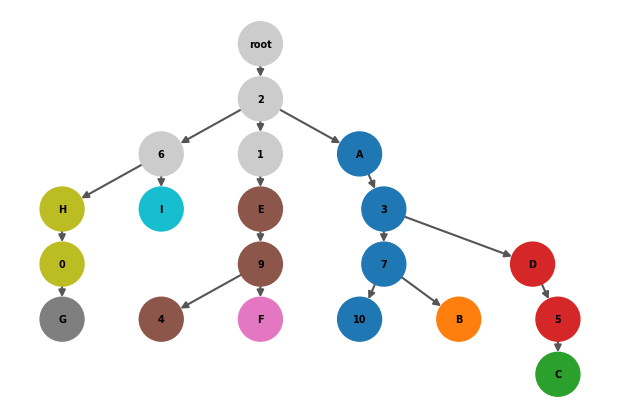

11


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


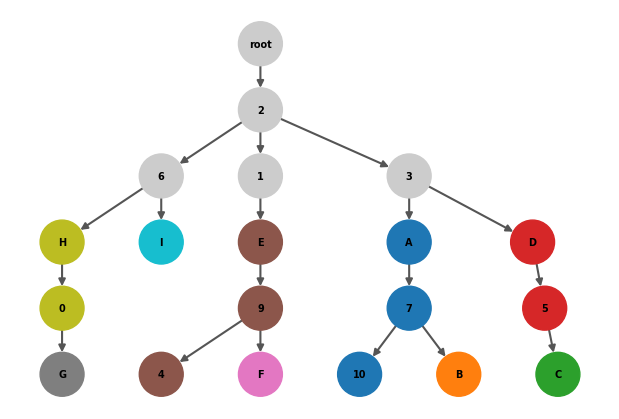

12


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


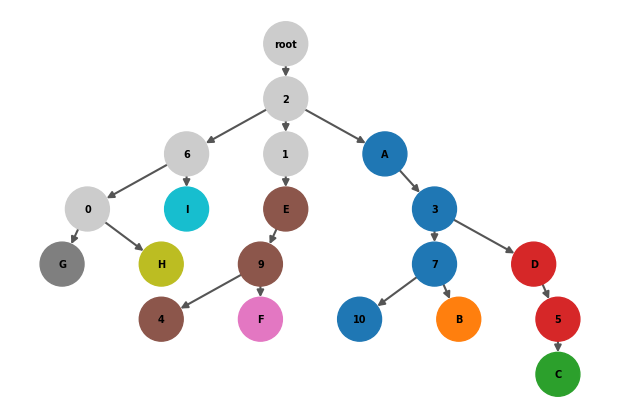

13


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


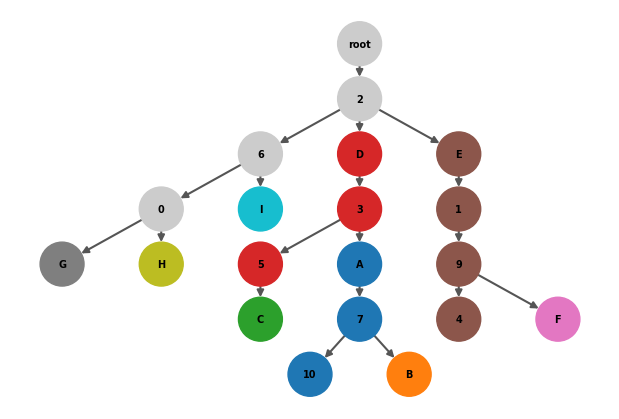

14


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


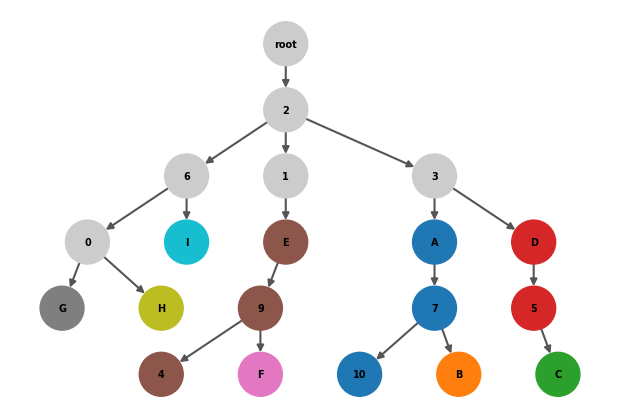

15


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


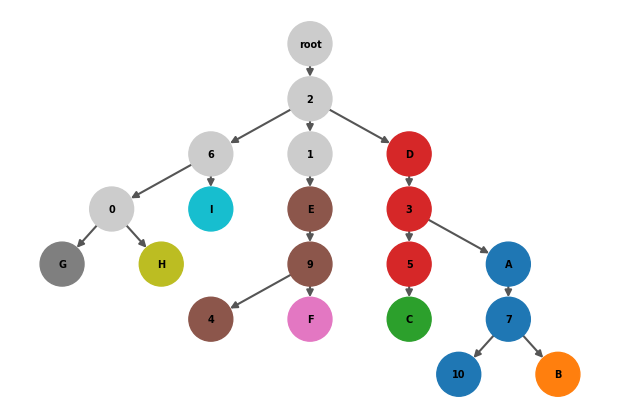

16


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


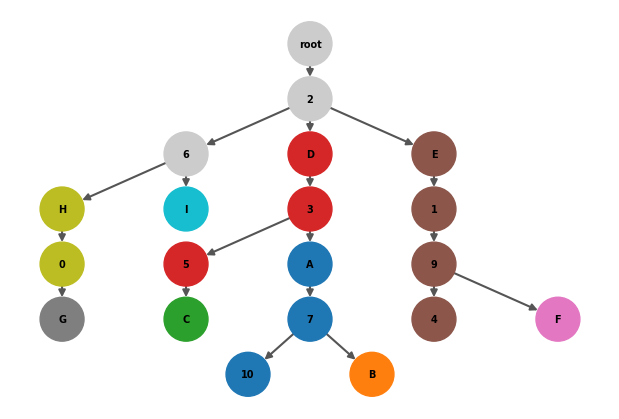

17


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


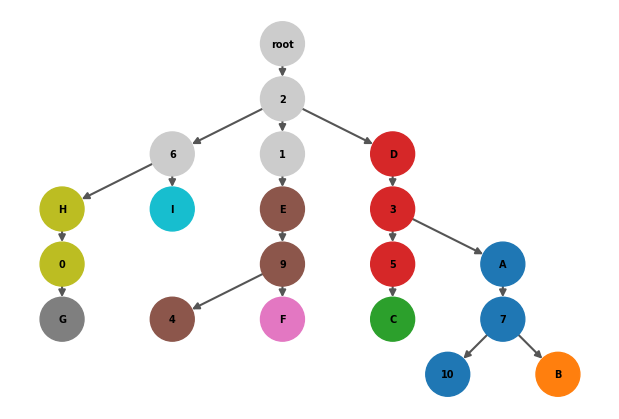

In [57]:
unique_solutions = []
solution_strs = {}

for i, solution in enumerate(solutions):
    try:
        X, B, U, F, G = solution
        solT_mut, solT_cell = generate_perfect_phylogeny(B)
        fixed_T = add_clusters_to_clonal_T(solT_mut, X, G, B)
        T_code = canonical_form(fixed_T)

        if T_code not in solution_strs:
            print(i)
            solution_strs[T_code] = i
            unique_solutions.append(solution)
            draw_clone_tree(fixed_T)
        else:
            print(i, 'same as', solution_strs[T_code])
        
    except Exception as e:
        print(e)

In [58]:
len(unique_solutions)

18

# p-value estimation of clones in clusters

In [106]:
df = pd.read_csv("../data/laks/ov2295_snv_counts.csv.gz")
df

/var/folders/nz/jn74t1g51q10qyclfkkr8cgm0000gq/T/ipykernel_83374/1233452112.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/laks/ov2295_snv_counts.csv.gz")


,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921
...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090


In [107]:
df["mutation"] = df["chrom"].astype(str) + ":" + df['coord'].astype(str) + ":" + df['ref'] + ":" +  df['alt']
df

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id,mutation
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,1:19671432:C:T
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,1:19671432:C:T
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,1:19671432:C:T
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,1:19671432:C:T
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,1:19671432:C:T
...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,5:62716827:T:A
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,5:62716827:T:A
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,5:62716827:T:A
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,5:62716827:T:A


In [108]:
df_2 = pd.read_csv("../data/laks/ov2295_clone_clusters.csv.gz")
df = pd.merge(df, df_2, on='cell_id', how='left')
df

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id,mutation,clone_id
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,1:19671432:C:T,NaN
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,1:19671432:C:T,H
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,1:19671432:C:T,H
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,1:19671432:C:T,NaN
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,1:19671432:C:T,I
...,...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,5:62716827:T:A,D
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,5:62716827:T:A,C
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,5:62716827:T:A,A
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,5:62716827:T:A,C


In [109]:
df_cell_cn = pd.read_csv("../scratch/data/ov2295_cell_cn.csv.gz")
df_cell_cn

,cell_id,sample_id,library_id,chr,start,end,reads,copy,state
0,SA922-A90554B-R34-C70,SA922,A90554B,1,1,500000,13,NaN,6
1,SA922-A90554B-R34-C70,SA922,A90554B,1,500001,1000000,442,NaN,6
2,SA922-A90554B-R34-C70,SA922,A90554B,1,1000001,1500000,461,6.672340,6
3,SA922-A90554B-R34-C70,SA922,A90554B,1,1500001,2000000,478,5.211916,6
4,SA922-A90554B-R34-C70,SA922,A90554B,1,2000001,2500000,594,8.384862,6
...,...,...,...,...,...,...,...,...,...
12200991,SA1090-A96213A-R29-C58,SA1090,A96213A,Y,57000001,57500000,0,NaN,0
12200992,SA1090-A96213A-R29-C58,SA1090,A96213A,Y,57500001,58000000,0,NaN,0
12200993,SA1090-A96213A-R29-C58,SA1090,A96213A,Y,58000001,58500000,0,NaN,0
12200994,SA1090-A96213A-R29-C58,SA1090,A96213A,Y,58500001,59000000,81,NaN,0


In [110]:
binsize = int(df_cell_cn['end'][0])
binsize

500000

In [111]:
df = df.copy()
df['bin'] = df['coord'] // binsize * binsize + 1
df

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id,mutation,clone_id,bin
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,1:19671432:C:T,NaN,19500001
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,1:19671432:C:T,H,19500001
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,1:19671432:C:T,H,19500001
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,1:19671432:C:T,NaN,19500001
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,1:19671432:C:T,I,19500001
...,...,...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,5:62716827:T:A,D,62500001
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,5:62716827:T:A,C,62500001
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,5:62716827:T:A,A,62500001
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,5:62716827:T:A,C,62500001


In [112]:
df['chrom'] = df['chrom'].astype(str)
df = pd.merge(df, df_cell_cn, left_on=['cell_id', 'chrom', 'bin'], right_on=['cell_id', 'chr', 'start'], how='left')
df

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id_x,mutation,clone_id,bin,sample_id_y,library_id,chr,start,end,reads,copy,state
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,1:19671432:C:T,NaN,19500001,SA921,A90554A,1,19500001,20000000,2,1.000000,1
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,1:19671432:C:T,H,19500001,SA921,A90554A,1,19500001,20000000,776,1.944033,2
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,1:19671432:C:T,H,19500001,SA921,A90554A,1,19500001,20000000,854,2.325511,2
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,1:19671432:C:T,NaN,19500001,SA921,A90554A,1,19500001,20000000,663,1.979604,2
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,1:19671432:C:T,I,19500001,SA921,A90554A,1,19500001,20000000,530,1.829550,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,5:62716827:T:A,D,62500001,SA1090,A96213A,5,62500001,63000000,209,0.988248,1
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,5:62716827:T:A,C,62500001,SA1090,A96213A,5,62500001,63000000,384,0.924362,1
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,5:62716827:T:A,A,62500001,SA1090,A96213A,5,62500001,63000000,456,1.219741,1
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,5:62716827:T:A,C,62500001,SA1090,A96213A,5,62500001,63000000,269,1.061080,1


In [113]:
df_cell_snv = pd.read_csv("/Users/samin/workspace/scWGS-Tumor-Phylogeny/scratch/data/ov2295_snv_counts.csv.gz", low_memory=False)
df_cell_snv

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921
...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090


In [114]:
df = df_cell_snv
df["bin_start"] = df["coord"] // binsize * binsize + 1
df

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id,bin_start
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,19500001
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,19500001
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,19500001
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,19500001
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,19500001
...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,62500001
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,62500001
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,62500001
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,62500001


In [115]:
df = pd.merge(df, df_cell_cn, left_on=['cell_id', 'chrom', 'bin_start'], right_on=['cell_id', 'chr', 'start'], how='left')
df

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id_x,bin_start,sample_id_y,library_id,chr,start,end,reads,copy,state
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,19500001,SA921,A90554A,1,19500001,20000000,2,1.000000,1
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,19500001,SA921,A90554A,1,19500001,20000000,776,1.944033,2
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,19500001,SA921,A90554A,1,19500001,20000000,854,2.325511,2
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,19500001,SA921,A90554A,1,19500001,20000000,663,1.979604,2
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,19500001,SA921,A90554A,1,19500001,20000000,530,1.829550,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,209,0.988248,1
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,384,0.924362,1
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,456,1.219741,1
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,269,1.061080,1


In [116]:
df["mutation"] = df["chrom"].astype(str) + ":" + df["coord"].astype(str) + ":" + df["ref"] + ":" + df["alt"]
df

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id_x,bin_start,sample_id_y,library_id,chr,start,end,reads,copy,state,mutation
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,19500001,SA921,A90554A,1,19500001,20000000,2,1.000000,1,1:19671432:C:T
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,19500001,SA921,A90554A,1,19500001,20000000,776,1.944033,2,1:19671432:C:T
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,19500001,SA921,A90554A,1,19500001,20000000,854,2.325511,2,1:19671432:C:T
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,19500001,SA921,A90554A,1,19500001,20000000,663,1.979604,2,1:19671432:C:T
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,19500001,SA921,A90554A,1,19500001,20000000,530,1.829550,2,1:19671432:C:T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,209,0.988248,1,5:62716827:T:A
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,384,0.924362,1,5:62716827:T:A
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,456,1.219741,1,5:62716827:T:A
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,269,1.061080,1,5:62716827:T:A


In [117]:
df_cell_clusters = pd.read_csv("/Users/samin/workspace/scWGS-Tumor-Phylogeny/scratch/data/ov2295_clone_clusters.csv.gz")
df_cell_clusters

,cell_id,clone_id
0,SA1090-A96213A-R20-C09,C
1,SA1090-A96213A-R20-C11,C
2,SA1090-A96213A-R20-C19,C
3,SA1090-A96213A-R20-C24,C
4,SA1090-A96213A-R20-C27,C
...,...,...
886,SA922-A90554B-R35-C24,F
887,SA922-A90554B-R35-C25,F
888,SA922-A90554B-R35-C37,F
889,SA922-A90554B-R35-C40,F


In [118]:
df = pd.merge(df, df_cell_clusters, on='cell_id', how='left')
df

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id_x,bin_start,sample_id_y,library_id,chr,start,end,reads,copy,state,mutation,clone_id
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,19500001,SA921,A90554A,1,19500001,20000000,2,1.000000,1,1:19671432:C:T,NaN
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,19500001,SA921,A90554A,1,19500001,20000000,776,1.944033,2,1:19671432:C:T,H
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,19500001,SA921,A90554A,1,19500001,20000000,854,2.325511,2,1:19671432:C:T,H
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,19500001,SA921,A90554A,1,19500001,20000000,663,1.979604,2,1:19671432:C:T,NaN
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,19500001,SA921,A90554A,1,19500001,20000000,530,1.829550,2,1:19671432:C:T,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,209,0.988248,1,5:62716827:T:A,D
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,384,0.924362,1,5:62716827:T:A,C
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,456,1.219741,1,5:62716827:T:A,A
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,269,1.061080,1,5:62716827:T:A,C


In [119]:
kmeans_labels

,mutation,clone
0,10:100129846:C:A,1
1,10:100185101:A:G,1
2,10:100209326:T:C,2
3,10:100283942:C:T,9
4,10:10086005:G:T,7
...,...,...
14063,X:98278474:C:A,0
14064,X:98452192:T:C,5
14065,X:98700894:C:T,2
14066,X:99136386:C:T,1


In [120]:
df = pd.merge(df, kmeans_labels, on='mutation', how='left')
df

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id_x,bin_start,...,library_id,chr,start,end,reads,copy,state,mutation,clone_id,clone
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,19500001,...,A90554A,1,19500001,20000000,2,1.000000,1,1:19671432:C:T,NaN,4
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,19500001,...,A90554A,1,19500001,20000000,776,1.944033,2,1:19671432:C:T,H,4
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,19500001,...,A90554A,1,19500001,20000000,854,2.325511,2,1:19671432:C:T,H,4
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,19500001,...,A90554A,1,19500001,20000000,663,1.979604,2,1:19671432:C:T,NaN,4
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,19500001,...,A90554A,1,19500001,20000000,530,1.829550,2,1:19671432:C:T,I,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,62500001,...,A96213A,5,62500001,63000000,209,0.988248,1,5:62716827:T:A,D,1
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,62500001,...,A96213A,5,62500001,63000000,384,0.924362,1,5:62716827:T:A,C,1
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,62500001,...,A96213A,5,62500001,63000000,456,1.219741,1,5:62716827:T:A,A,1
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,62500001,...,A96213A,5,62500001,63000000,269,1.061080,1,5:62716827:T:A,C,1


In [173]:
copy_number = 4

In [174]:
import pandas as pd
from scipy.stats import binom

# Define clusters and clones
clusters = ("A", "B", "C", "D", "E", "F", "G", "H", "I")
clones = sorted(kmeans_labels['clone'].unique().tolist())

# Initialize an empty DataFrame to store p-values
df_pvals = pd.DataFrame(index=clusters, columns=clones)
total = pd.DataFrame(index=clusters, columns=clones)
alt = pd.DataFrame(index=clusters, columns=clones)

# Loop over clusters and clones and fill the DataFrame
for cluster in clusters:
    for clone in clones:
        df_subset = df[(df['state'] == copy_number) & 
                       (df['clone_id'] == cluster) &
                       (df['clone'] == clone)]

        alt_counts = df_subset['alt_counts'].sum()
        total_counts = df_subset['total_counts'].sum()

        # skip if no reads to avoid errors
        if total_counts == 0:
            pval = None
        else:
            pval = binom.sf(alt_counts - 1, total_counts, 0.5)
        
        total.at[cluster, clone] = total_counts
        alt.at[cluster, clone] = alt_counts
        df_pvals.at[cluster, clone] = pval

# Convert to numeric (optional, for plotting)
df_pvals = df_pvals.astype(float)


In [175]:
total

,0,1,2,3,4,5,6,7,9,10
A,120,1280,1768,680,483,314,2188,400,749,101
B,106,1000,1211,505,417,251,1456,228,494,71
C,201,2046,2688,997,916,622,2887,584,1024,161
D,262,2497,3205,1347,1181,690,3515,640,1276,182
E,3145,25925,36999,13146,16373,7201,35789,7775,16126,2614
F,1767,14765,20738,7439,9025,4426,21435,4289,8223,1520
G,3667,30848,45487,17205,14812,8045,46545,9652,16910,3370
H,2309,19333,28385,10560,9298,4863,29088,6132,10543,2255
I,3228,28197,41632,15472,14228,7728,42286,9106,15225,3256


In [176]:
alt

,0,1,2,3,4,5,6,7,9,10
A,0,3,948,335,0,3,2,216,0,61
B,0,0,589,223,0,11,6,110,2,8
C,0,0,1484,550,3,262,5,7,0,1
D,2,0,1782,672,2,327,6,5,1,4
E,26,12676,19568,19,3884,11,31,6,7213,2
F,15,7287,11064,8,107,3,37,4,3652,2
G,893,38,24043,20,16,12,22613,13,16,8
H,646,22,15067,14,7,4,14131,6,10,1
I,103,34,22156,17,165,9,20498,17,19,6


In [177]:
true_p = 1 / copy_number
error_rate = 0.1
p_eff = true_p * (1 - error_rate)
print(p_eff)

pval_df = alt.copy()  # make a new dataframe
for row in alt.index:
    for col in alt.columns:
        X = alt.loc[row, col]
        n = total.loc[row, col]
        pval_df.loc[row, col] = binom.cdf(X, n, p_eff)

pval_df

0.225


,0,1,2,3,4,5,6,7,9,10
A,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
B,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.012288
C,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
D,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
E,0.0,1.0,1.0,0.0,0.999905,0.0,0.0,0.0,1.0,0.0
F,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
G,0.996362,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
H,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
I,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [178]:
num_counts_thres = 100
I = (1 - (pval_df < 0.05).astype(int))
I[total < num_counts_thres] = 'X'
I

/var/folders/nz/jn74t1g51q10qyclfkkr8cgm0000gq/T/ipykernel_83374/469335988.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'X' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  I[total < num_counts_thres] = 'X'


,0,1,2,3,4,5,6,7,9,10
A,0,0,1,1,0,0,0,1,0,1
B,0,0,1,1,0,0,0,1,0,X
C,0,0,1,1,0,1,0,0,0,0
D,0,0,1,1,0,1,0,0,0,0
E,0,1,1,0,1,0,0,0,1,0
F,0,1,1,0,0,0,0,0,1,0
G,1,0,1,0,0,0,1,0,0,0
H,1,0,1,0,0,0,1,0,0,0
I,0,0,1,0,0,0,1,0,0,0


/Users/samin/workspace/scWGS-Tumor-Phylogeny/notebooks/../src/phylogeny_utils.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


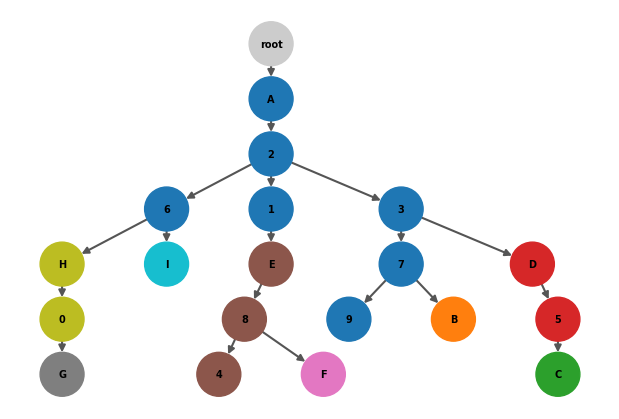

In [179]:
solution = solutions[32]
X, B, U, F, G = solution
solT_mut, solT_cell = generate_perfect_phylogeny(B)
fixed_T = add_clusters_to_clonal_T(solT_mut, X, G, B)

draw_clone_tree(fixed_T)

In [180]:
row_cols = []
import string
for i, cluster in enumerate(string.ascii_uppercase[:9], start=1):
    for j in range(10):
        if nx.has_path(fixed_T, j, cluster):
            print(cluster, j)
            row_cols.append((i - 1, j))

print(row_cols)

B 2
B 3
B 7
C 2
C 3
C 5
D 2
D 3
E 1
E 2
F 1
F 2
F 8
G 0
G 2
G 6
H 2
H 6
I 2
I 6
[(1, 2), (1, 3), (1, 7), (2, 2), (2, 3), (2, 5), (3, 2), (3, 3), (4, 1), (4, 2), (5, 1), (5, 2), (5, 8), (6, 0), (6, 2), (6, 6), (7, 2), (7, 6), (8, 2), (8, 6)]


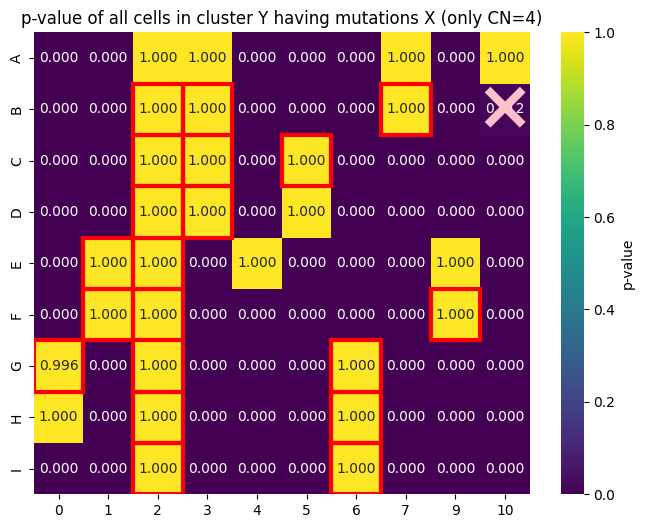

In [181]:
import seaborn as sns
import matplotlib.patches as patches

plt.figure(figsize=(8, 6))
sns.heatmap(pval_df.astype(float), annot=True, cmap='viridis', cbar_kws={'label': 'p-value'}, fmt=".3f")

for i in range(pval_df.astype(float).shape[0]):
    for j in range(pval_df.astype(float).shape[1]):
        if total.iloc[i, j] < 100:
            plt.text(j + 0.5, i + 0.5, '×', ha='center', va='center',
                     color='pink', fontsize=50, fontweight='bold')


for row, col in row_cols:

    rect = patches.Rectangle(
        (col, row),  # (x, y) = (col, row)
        1, 1,        # width, height of one cell
        fill=False,
        edgecolor='red',
        linewidth=3
    )

    ax = plt.gca()  # get current axes
    ax.add_patch(rect)

plt.title(f"p-value of all cells in cluster Y having mutations X (only CN={copy_number})")
plt.show()